# Предсказание экспрессии белка на основе графа

Датасет представляет собой граф взаимойдествия белков. Где узлы это белки, взаимодействие между белками это ребро.

Для каждого белка известен уровень его экспрессии. Информация по экспрессии белков, разбитая на train и test. Решается задача регрессии.

In [31]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import walker
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
%%time
edges = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv", sep=",")

CPU times: user 103 ms, sys: 94.1 ms, total: 197 ms
Wall time: 1.54 s


In [3]:
edges

,node_1,node_2
0,344,50
1,344,153
2,344,532
3,344,679
4,344,986
...,...,...
594169,14857,3544
594170,25040,11204
594171,697,20457
594172,27498,26633


In [4]:
train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/train.csv", sep=",")
train

,target,node
0,0.251968,11142
1,0.689541,2243
2,0.678245,15514
3,0.272500,20944
4,0.248888,8721
...,...,...
7995,0.329241,19479
7996,0.350863,2182
7997,0.288309,20535
7998,1.064300,9769


In [5]:
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/test.csv", sep=",")
test

,target,node
0,0.279231,817
1,0.380795,9574
2,0.686527,1607
3,0.303594,4782
4,0.367374,24125
...,...,...
1995,0.327932,1849
1996,0.278870,16977
1997,0.233343,5952
1998,0.866416,9067


## 1. Создание графа

Всего известно 10000 белков. При этом среднее количество связей для каждого узла достаточно высоко. Визуализировать граф не имеет смысла, т.к. мы практически получим картину "все со всеми".

In [6]:
edges.node_1.nunique(), edges.node_2.nunique()

(9889, 9862)

In [44]:
edges.groupby('node_1').count().median()

node_2    38.0
dtype: float64

In [35]:
G = nx.from_pandas_edgelist(edges, 'node_1', 'node_2', create_using=nx.Graph())

## 2. Векторизация узлов
### 2.1. DFS-type

Для векторизации сгенерируем случайные блуждания. 

Параметры p и q отвечают за вероятность возвращения в только что посещенную ноду и веротность ухода дальше от текущей ноды соответственно. Следовательно, при малых значениях q (т.к. используется параметр 1/q), мы способствуем обходу графа в глубину (DFS). В нашем случае, с высоким количеством связей каждого узла, мне кажется интуитивным использовать именно такой подход. Для проверки гипотезы так же проверим и BFS. Длину блужданий выставим побольше.

In [64]:
%%time
rw = walker.random_walks(G, n_walks=50, walk_len=40, p=0.25, q=0.01)

Random walks - T=74.93s
CPU times: user 13min 27s, sys: 2.73 s, total: 13min 30s
Wall time: 1min 14s


In [66]:
rw.shape

(500000, 40)

In [111]:
node_list = list(G.nodes())

In [112]:
walks = [[str(node_list[x]) for x in line] for line in rw]

Для обучения эмбеддингов испольуем Word2Vec

In [114]:
%%time
model = Word2Vec(walks, vector_size=100, workers=6, sg=1, epochs=5)

CPU times: user 9min 40s, sys: 1.88 s, total: 9min 42s
Wall time: 1min 40s


In [116]:
X_train = np.asarray([model.wv[str(node)] for node in train.node.values])
X_test = np.asarray([model.wv[str(node)] for node in test.node.values])

Для визуализации эмбеддингов можно использзовать TSNE.

In [178]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X_train[:1000])

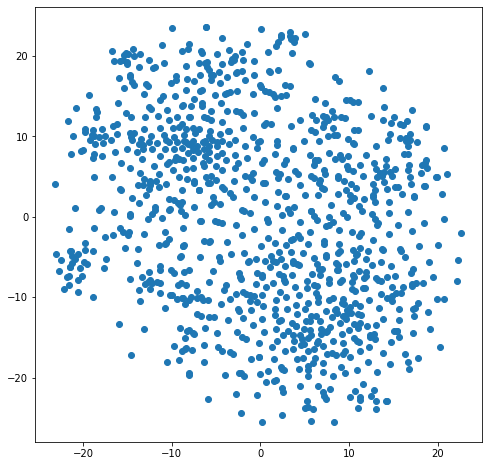

In [121]:
plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

Скаттерплот показывает незначительные скопления, но нельзя сказать, что они существенны для выделения дополнительных признаков из групп белков.
В качестве модели регрессии будет использована самая простая модель из sklearn.

In [177]:
regression = LinearRegression()
regression.fit(X_train, train.target.values)

LinearRegression()

In [125]:
regression.score(X_test, test.target.values)

0.6231584642474046

In [126]:
mean_squared_error(regression.predict(X_test), test.target.values)

0.2834168024414281

### 2.2. BFS-type

Теперь при тех же параметрах попробуем обойти граф больше в ширину, увеличив q.

In [127]:
%%time
rw = walker.random_walks(G, n_walks=50, walk_len=40, p=0.25, q=0.5)

Random walks - T=72.95s
CPU times: user 13min 41s, sys: 1.35 s, total: 13min 42s
Wall time: 1min 12s


In [128]:
walks = [[str(node_list[x]) for x in line] for line in rw]

In [129]:
%%time
model = Word2Vec(walks, vector_size=100, workers=6, sg=1, epochs=5)

CPU times: user 9min 58s, sys: 1.36 s, total: 9min 59s
Wall time: 1min 42s


In [130]:
X_train = np.asarray([model.wv[str(node)] for node in train.node.values])
X_test = np.asarray([model.wv[str(node)] for node in test.node.values])

In [179]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X_train[:1000])

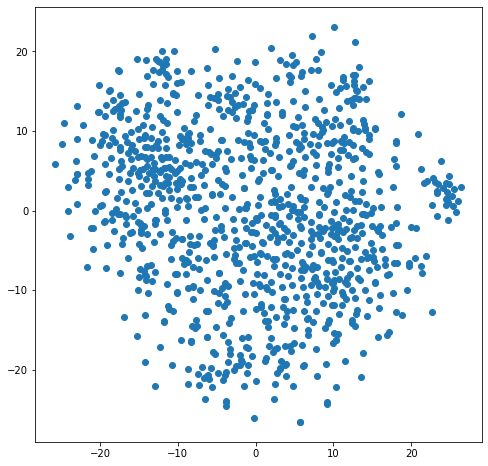

In [132]:
plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [133]:
regression = LinearRegression()
regression.fit(X_train, train.target.values)

LinearRegression()

In [134]:
regression.score(X_test, test.target.values)

0.5932604376616358

In [135]:
mean_squared_error(regression.predict(X_test), test.target.values)

0.3059026546905032

Результаты ухудшились, из чего можно сделать вывод, что для данного графа предпочтительней использовать DFS при случайном блуждании. Можно немного улучшить MSE, увеличив длину блужданий и количество эпох обучения Word2Vec.

## 3. Стандартные метрики графа

Здесь для выделения признаков используем:
* degree_centrality
* betweenness_centrality
* closeness_centrality

In [180]:
degree_centrality = nx.degree_centrality(G)

In [191]:
%%time
betweenness_centrality = nx.betweenness_centrality(G, k=100)

CPU times: user 36.2 s, sys: 27.6 ms, total: 36.2 s
Wall time: 36.2 s


К сожалению, расчет близости занимет слишком много времени, попробуем обойтись без него.

In [203]:
# closeness_centrality = nx.closeness_centrality(G)

In [198]:
train_features = np.zeros((train.shape[0], 2))
for i, node in enumerate(train.node.values):
    train_features[i, 0] = degree_centrality[node]
    train_features[i, 1] = betweenness_centrality[node]
    # train_features[i, 2] = closeness_centrality[node]
    
test_features = np.zeros((test.shape[0], 2))
for i, node in enumerate(test.node.values):
    test_features[i, 0] = degree_centrality[node]
    test_features[i, 1] = betweenness_centrality[node]
    # test_features[i, 2] = closeness_centrality[node]

In [223]:
lr = LinearRegression()
lr.fit(train_features, train.target.values)

LinearRegression()

In [224]:
lr.score(test_features, test.target.values)

0.9842614454422908

In [227]:
mean_squared_error(lr.predict(test_features), test.target.values)

0.011836728132655681

Поразительные результаты. Самые простые метрики дали почти R2-score почти 1 и гораздо меньшую MSE, чем сложные модели.

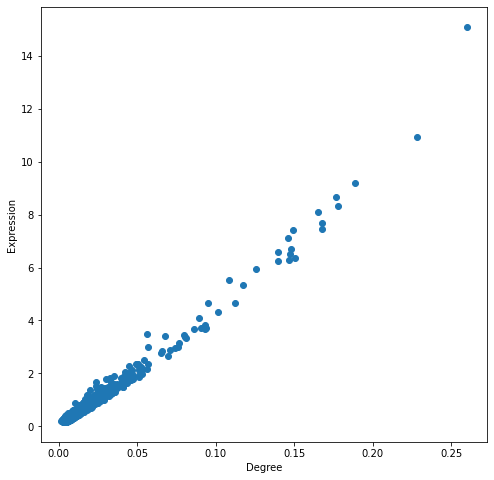

In [228]:
plt.figure(figsize=(8, 8))
plt.scatter(test_features[:, 0], test.target.values)
plt.xlabel('Degree')
plt.ylabel('Expression')
plt.show()

Более того, оказывается самый сильный признак - degree centrality. Как видно на графике, экспрессия имеет прямую линейную зависимость от количества связей белка. Очевидный способ улучшить результаты - дождаться расчета меры близости и увеличить количество семплов для меры посредничества.